In [70]:
import collections
import pickle

import os
import numpy as np
import pandas as pd

import tensorflow as tf

In [71]:
tf.config.experimental.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Utils

In [72]:
image_size=(54,128)
def savepickle(fname,*args):
    with open(fname+"_pk","wb") as f:
        pickle.dump(args,f)
        
def loadpickle(fname):
    with open(fname,"rb") as f:
        obj = pickle.load(f)
        
    return obj

def reformat(x):
    """
    input: x = array([[array([5.]), 1])
    output: x = array([5,0,0,0,0])
    """
    x = list(x[0])
    #只截取5个，因为模型只输出5个
    x = x[:5]
    p = len(x)
    x = x + [0]*(5-p)
    return np.array(x)

def load_data(rootdir,pk="digitStruct.mat_pk",num_only=True):
    #pk_path = os.path.join(rootdir,pk)
    image_names,labels = loadpickle(pk)
    
    labels_x_len = labels[:,-1:] 
    labels_x_len[labels_x_len>5]=6
    labels_x_len = labels_x_len.astype(float)
    labels_num = np.apply_along_axis(reformat,1,labels)
    labels = np.concatenate((labels_x_len,labels_num),axis=1)
    image_names = np.array([os.path.join(rootdir,x) for x in image_names])
    if num_only:
        return image_names,labels_num

    return image_names,labels

def to_df(x,y):
    xdf = pd.DataFrame(x,columns=["filename"])
    #这样有问题，应该 dataset = pd.DataFrame({'Column1': data[:, 0], 'Column2': data[:, 1]})
    ydf = pd.DataFrame(y,columns=["len","1","2","3","4","5"])
    ydf = ydf.astype(int)
    
    return pd.concat([xdf,ydf],axis=1)

def to_one_hot(n_arr,cls_num):
    onehot = np.zeros((n_arr.shape[1],cls_num))
    onehot[np.arange(n_arr.shape[1]),n_arr]=1
    return onehot


def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, image_size)
    image /= 255.0  # normalize to [0,1] range
    image -= tf.math.reduce_mean(image,keepdims=True)
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def datset_gen(images,lables,batch_size=16,buffer_size=1000):

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    path_ds = tf.data.Dataset.from_tensor_slices(images)
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
    label_ds = tf.data.Dataset.from_tensor_slices(lables)
    img_lab_ds = tf.data.Dataset.zip((image_ds, label_ds))

    return img_lab_ds.shuffle(buffer_size=buffer_size).repeat().batch(batch_size)

## Models

In [73]:
import matplotlib.pyplot as plt

def plt_images(x,ylab=None,is_path=True,num=8):
    indices = np.arange(x.shape[0])
    n=1
    for i in np.random.choice(indices,num):
        plt.subplot(4,4,n)
        img = x[i]
        if is_path:
            img = tf.io.read_file(img)
            img = tf.image.decode_jpeg(img, channels=3)
         
        plt.imshow(img)
        #plt.axis("off")
        n+=2
        if ylab is not None:
            yl = str(ylab[i])
            xs = str(img.shape)
            plt.text(0,-10,"".join((yl,xs)),ha="left", va="bottom", size="medium",color="red")
    plt.show()


In [74]:
import tensorflow as tf
from tensorflow import keras
from functools import partial
import numpy as np 
from tensorflow.keras.layers import Flatten,Dense,Activation,MaxPool2D,GlobalAvgPool2D,BatchNormalization
from tensorflow.keras.layers import Input,Conv2D,Lambda,Dropout
from tensorflow.keras import Model


DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,kernel_initializer='random_uniform',
                        padding="SAME", use_bias=False)



In [75]:
def test_cnn(input_):
    #image_in_vision = Input(shape=(image_size[0],image_size[1],3))
    x = BatchNormalization()(input_)
    for filter in [32]*2+[64]*1+[128]*1 :
        x = DefaultConv2D(filter, strides=2, activation='relu')(x)
        x = BatchNormalization()(x)
        x = DefaultConv2D(filter, strides=1, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        x = MaxPool2D(pool_size=(2,2), padding="SAME")(x)
   
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(1024, activation='relu')(x)
    h = BatchNormalization()(x)

    return h

def svhn_model_simple(input_shape=[54,128,3],N=5,class_num=11):
    X=Input(shape=input_shape)
    y = test_cnn(X)
    #y = Dense(192,activation="relu",kernel_initializer='he_normal')(y)
    #y = Dense(512,activation="relu",kernel_initializer='he_normal')(y)
    S = [ Dense(class_num,activation="softmax",kernel_initializer='he_normal',name="cls_".join(str(n)))(y) for n in range(N) ]
    S = tf.stack(S,axis=1)
    #S = Dense(N+2,activation="softmax",kernel_initializer='he_normal')(y)
    return Model(inputs=X,outputs=S)

## Train

In [76]:
root_path = "/kaggle/input/street-view-house-numbers/"
train_path ="/kaggle/input/svhnpk/train_digitStruct.mat_pk"
test_path =  "/kaggle/input/svhnpk/test_digitStruct.mat_pk"
extra_path = "/kaggle/input/svhnpk/extra_digitStruct.mat_pk"
is_num_only=True
X_test,y_test = load_data(root_path+"test/test/",test_path,num_only=is_num_only)
X_train,y_train = load_data(root_path+"train/train/",train_path,num_only=is_num_only)
X_extra,y_extra = load_data(root_path+"extra/extra/",extra_path,num_only=is_num_only)

X_train = np.concatenate([X_train,X_extra])
y_train = np.concatenate([y_train,y_extra])
y_train = y_train.reshape((-1,5,1))
y_test = y_test.reshape((-1,5,1))

In [77]:
batch_size  = 64
ds_train = datset_gen(X_train,y_train,batch_size=batch_size,buffer_size=100)
ds_test = datset_gen(X_test,y_test,batch_size=batch_size,buffer_size=100)

In [78]:
print(X_train.shape,y_train.shape)

(235755,) (235755, 5, 1)


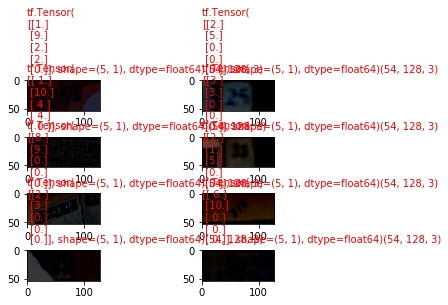

In [79]:
for x,y in ds_train.take(1):
    plt_images(x,y,False)
    
    

In [80]:
# model = svhn_train(ds_train,
#                num_epochs=100,
#                learning_rate=0.01,
#                input_shape=[32,32,3],
#                CNNModel=ResNet34,
#                N=5,class_num=11)

In [81]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8,8))
# for n, image in enumerate(ds_train.take(1)):
#   plt.subplot(2,2,n+1)
#   plt.imshow(image)
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   plt.xlabel(caption_image(all_image_paths[n]))
#   plt.show()

In [82]:
loss_cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model = svhn_model_simple(input_shape=[54,128,3])
optimizer = tf.keras.optimizers.Adamax(learning_rate=0.05,clipvalue=1)

# - 该模型5个位置，分别计算LOSS
model.compile(optimizer=optimizer,
              loss=loss_cce,
              metrics=['accuracy'])

In [83]:

#tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
#checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="checkpoint_"+model_save_file, verbose=1)

In [84]:
#model.summary()

In [85]:
num_epoches=50
def scheduler(epoch):
  if epoch < 10:
    return 0.1
  else:
    return 0.01 * tf.math.exp(0.1 * (10 - epoch))

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)
with tf.device("/GPU:0"):
    history = model.fit_generator(ds_train,
                steps_per_epoch=X_train.shape[0]//batch_size,
                epochs=num_epoches,
                validation_data=ds_test,
                validation_steps=100,callbacks=[lr_cb])

Train for 3683 steps, validate for 100 steps
Epoch 1/50
2859/3683 [======================>.......] - ETA: 56s - loss: 1.9922 - accuracy: 0.5508

KeyboardInterrupt: 

In [ ]:
weights = model.get_weights()

In [ ]:
model.save("model.cnnorg.h5")
savepickle("weitgh_only.h5",weights)

#-- visualize --
import matplotlib.pyplot as plt

#import matplotlib as mpl
#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epoches)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# class LossHistory(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.losses = []

#     def on_batch_end(self, batch, logs={}):
#         self.losses.append(logs.get('loss'))